In [1]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = os.path.realpath("../data/WESAD")

In [102]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']
    
    def get_subject_dataframe(self):
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
       # df = (df-df.min())/(df.max()-df.min()) # Normalize data (no train test leakage since data frame per subject)
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        return df


In [103]:
s_10_df = Subject(DATA_PATH, 10).get_subject_dataframe()

In [104]:
s_10_df.describe()

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
count,145728.000000,145728.000000,145728.000000,145728.000000,145728.000000,145728.000000,145728.000000
mean,0.017492,1.071108,43.384344,1.108408,9.436471,33.688991,0.318401
std,46.410252,1.008972,17.520316,25.840410,32.475573,0.371620,0.465858
min,-440.190000,0.331912,-35.949821,-68.000000,-76.253821,32.902600,0.000000
25%,-13.270000,0.399136,34.461792,-21.901780,-21.000000,33.369566,0.000000
50%,2.430000,0.424644,51.000000,2.302454,0.963015,33.710000,0.000000
75%,13.360000,2.040967,57.000000,8.069503,46.670699,34.030000,1.000000
max,705.550000,3.511492,148.865822,80.000000,91.000000,34.316330,1.000000


In [31]:
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
subjects_data = {}
for subject_num in subjects:
    subject = Subject(DATA_PATH, subject_num)
    subjects_data[subject.name] = subject.get_subject_dataframe()


In [101]:
subjects_data['S10']

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,0.380454,0.037829,0.431863,0.620424,0.545657,0.651013,0.0
1,0.386091,0.036998,0.434247,0.622652,0.544809,0.650849,0.0
2,0.395530,0.036225,0.431863,0.625168,0.542255,0.650657,0.0
3,0.409109,0.035537,0.428765,0.628173,0.540661,0.650438,0.0
4,0.426086,0.034959,0.431863,0.629913,0.538854,0.650191,0.0
...,...,...,...,...,...,...,...
145723,0.436886,0.416690,0.540589,0.501608,0.242877,0.574979,1.0
145724,0.435813,0.416645,0.542032,0.501806,0.242948,0.574981,1.0
145725,0.434373,0.416605,0.543469,0.502008,0.243001,0.574983,1.0
145726,0.432538,0.416571,0.542032,0.501806,0.242948,0.574984,1.0


##### Anwendung von Fourier Transformation (scipy.fft) am Beispiel: https://realpython.com/python-scipy-fft/
Wichtige Parameter:
1. **SAMPLE_RATE** (in Hertz) determines how many data points the signal uses to represent the sine wave per second. So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.
2. **DURATION** (in Seconds) is the length of the generated sample. -> Frage hierzu: können wir überhaupt duration in seconds nehmen, wenn wir gar nicht mit den Zeitstempeln arbeiten, oder ist das irrelvant?

Für *fftfreq* wird N (= SAMPLE_RATE * DURATION) und 1/SAMPLE_RATE

### Window

In [33]:
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [34]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

In [35]:
def create_windows(df: pd.DataFrame) -> tuple[pd.DataFrame,list]:

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

In [36]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

In [37]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)
        freqs.append(freq)
        yfs.append(yf)
    return freqs, yfs
    

In [38]:
def fft_subwindows_new(subwindows: list, duration: int, f_s: int) -> list:
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        freq = scipy.fft.fftfreq(l)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending w.r.t amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        # amps_std = np.std(amps)
        # freq_std = np.std(freq)

        freqs.append(freq)
        yfs.append(amps)
        # freqs = np.append(np.array(freqs), freq)
        # yfs = np.append(np.array(yfs), amps)
    return np.asarray(freqs), np.asarray(yfs)
    

In [39]:
def average_window(subwindows_fft: list) -> list:
    # len_list_yfs = [len(subwindows_fft[i]) for i in range(len(subwindows_fft))]
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [12]:
windows, labels = create_windows(df)
yfs_per_min_for_signal = {}
X = []
for i in range(0,len(windows) - 1):
    for signal in signal_subwindow_dict.keys():

        duration_in_sec = signal_subwindow_dict[signal]

        subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
        freqs, yfs = fft_subwindows_new(subwindows, duration_in_sec, 64)
        yfs_average = average_window(yfs)[:210]
        yfs_per_min_for_signal[signal] = yfs_average
        
    X.append(pd.DataFrame(yfs_per_min_for_signal).T)
y = list(labels[:len(windows)-1])

NameError: name 'df' is not defined

In [40]:
#{S10: X:[], y:[])}
subjects_preprosessed_data = {}
for subject_name, subject_df in subjects_data.items():
    subjects_preprosessed_data[subject_name] = {}
    windows, labels = create_windows(subject_df)
    yfs_per_min_for_signal = {}
    X = []
    for i in range(0,len(windows) - 1):
        for signal in signal_subwindow_dict.keys():

            duration_in_sec = signal_subwindow_dict[signal]

            subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
            freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
            yfs_average = average_window(yfs)[:210]
            yfs_per_min_for_signal[signal] = yfs_average
            
        X.append(pd.DataFrame(yfs_per_min_for_signal).T)
    y = list(labels[:len(windows)-1])
    subjects_preprosessed_data[subject_name]['X'] = X
    subjects_preprosessed_data[subject_name]['y'] = y


In [41]:
all_subjects_X = []
all_subjects_y = []
for subject_name, subject_data in subjects_preprosessed_data.items():
    all_subjects_X.append(subject_data['X'])
    all_subjects_y.append(subject_data['y'])


# Model

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler

In [52]:
def build_model(num_signals: int, num_output_class: int) -> tf.keras.models.Sequential:
    # Define the model architecture
    model = tf.keras.Sequential()
    #input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    #hier fehlen: Output shape, was bringt mir param#, kernel_size != Kernels, Size?
    model.add(tf.keras.layers.Dropout(rate=0.3)) # portion gibts nicht? und es ist 'rate' gefordert???
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))#, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))#, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    #Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid'))#, kernel_initializer='glorot_uniform'))

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def normalize(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [146]:
groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
num_signals = 6
num_output_class = 2
num_epochs = 10

all_acc_histories = []
all_loss_histories = []

all_scores = []

for i in groups_set:
    test_index = groups_set[i]
    train_index = [x for x in groups_set if x != test_index]
    print(train_index, test_index)

    X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
    y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))
    X_test = all_subjects_X[test_index]
    y_test = all_subjects_y[test_index]

    weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    #tf.keras.backend.clear_session()

    y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

    tf.keras.backend.clear_session()

    model = build_model(num_signals, num_output_class)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"wesad_binary_s{test_index}.h5",  # Path to save the model file
        monitor="loss", # The metric name to monitor
        save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss", # Quantity to be monitored.
        min_delta=0.01,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=10,        # Number of epochs with no improvement after which training will be stopped.
    )

    history = model.fit(
    X_train, 
    y_train,
    # validation_data=(X_test, y_test),
    epochs=num_epochs, 
    batch_size=50,
    verbose=1,
    class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the data
    callbacks = [checkpoint]#, early_stopping]
)   
    #acc_history = history.history['val_accuracy']
    #loss_history = history.history['val_loss']
    #all_acc_histories.append(acc_history)
    #all_loss_histories.append(loss_history)
    score = model.evaluate(X_test, y_test, verbose=0) 
    # print('Test loss:', round(score[0], 2)) 
    # print('Test accuracy:', round(score[1], 2))

    # test_loss.append(score[0])
    # test_acc.append(score[1])
    all_scores.append(score)

    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 0
Epoch 1/10


/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_1476/2526669827.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_1476/2526669827.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))


11/11 [==============================] - 1s 45ms/step - loss: 4.0846 - accuracy: 0.6667
Epoch 2/10
11/11 [==============================] - 0s 44ms/step - loss: 1.2869 - accuracy: 0.7216
Epoch 3/10
11/11 [==============================] - 0s 44ms/step - loss: 1.0380 - accuracy: 0.7961
Epoch 4/10
11/11 [==============================] - 1s 45ms/step - loss: 0.9806 - accuracy: 0.7706
Epoch 5/10
11/11 [==============================] - 0s 44ms/step - loss: 0.7804 - accuracy: 0.8078
Epoch 6/10
11/11 [==============================] - 0s 44ms/step - loss: 0.7328 - accuracy: 0.8157
Epoch 7/10
11/11 [==============================] - 0s 44ms/step - loss: 0.7568 - accuracy: 0.8118
Epoch 8/10
11/11 [==============================] - 0s 44ms/step - loss: 0.8056 - accuracy: 0.7804
Epoch 9/10
11/11 [==============================] - 0s 45ms/step - loss: 0.7038 - accuracy: 0.8235
Epoch 10/10
11/11 [==============================] - 0s 45ms/step - loss: 0.6517 - accuracy: 0.8314
[0, 2, 3, 4, 5, 6, 7

In [141]:
for i in groups_set:
    print(f'Subject {i}\nMax Accurary: {max(all_acc_histories[i])}\nMin Loss: {min(all_loss_histories[i])}\n')

Subject 0
Max Accurary: 0.9714285731315613
Min Loss: 0.27669352293014526

Subject 1
Max Accurary: 0.800000011920929
Min Loss: 0.4736672043800354

Subject 2
Max Accurary: 1.0
Min Loss: 0.0959198996424675

Subject 3
Max Accurary: 1.0
Min Loss: 0.20394562184810638

Subject 4
Max Accurary: 0.9722222089767456
Min Loss: 0.13313668966293335

Subject 5
Max Accurary: 1.0
Min Loss: 0.1896345168352127

Subject 6
Max Accurary: 1.0
Min Loss: 0.17317478358745575

Subject 7
Max Accurary: 0.9722222089767456
Min Loss: 0.24084478616714478

Subject 8
Max Accurary: 1.0
Min Loss: 0.09136440604925156

Subject 9
Max Accurary: 0.8648648858070374
Min Loss: 0.4154405891895294

Subject 10
Max Accurary: 1.0
Min Loss: 0.15251615643501282

Subject 11
Max Accurary: 0.7027027010917664
Min Loss: 0.7087381482124329

Subject 12
Max Accurary: 1.0
Min Loss: 0.19975809752941132

Subject 13
Max Accurary: 1.0
Min Loss: 0.1782628297805786

Subject 14
Max Accurary: 0.7297297120094299
Min Loss: 0.4891062080860138



[0.5643645524978638, 0.7428571581840515]

In [155]:
all_scores[0][0]

0.4582371711730957

In [157]:
all_scores

[[0.4582371711730957, 0.8571428656578064],
 [0.5643645524978638, 0.7428571581840515],
 [0.20774409174919128, 1.0],
 [0.19472549855709076, 1.0],
 [0.20889171957969666, 0.9722222089767456],
 [0.45748409628868103, 0.9444444179534912],
 [0.4060139060020447, 0.9722222089767456],
 [0.5993079543113708, 0.6388888955116272],
 [0.14154163002967834, 1.0],
 [0.6408984065055847, 0.7567567825317383],
 [0.42695778608322144, 0.7837837934494019],
 [0.7229179739952087, 0.29729729890823364],
 [0.3181799650192261, 1.0],
 [0.4798763394355774, 0.8918918967247009],
 [1.0553820133209229, 0.29729729890823364]]

In [156]:
for i in groups_set:
    print(f'{i}: {all_scores[i][1]}')

0: 0.8571428656578064
1: 0.7428571581840515
2: 1.0
3: 1.0
4: 0.9722222089767456
5: 0.9444444179534912
6: 0.9722222089767456
7: 0.6388888955116272
8: 1.0
9: 0.7567567825317383
10: 0.7837837934494019
11: 0.29729729890823364
12: 1.0
13: 0.8918918967247009
14: 0.29729729890823364


### 200 EPOCHS

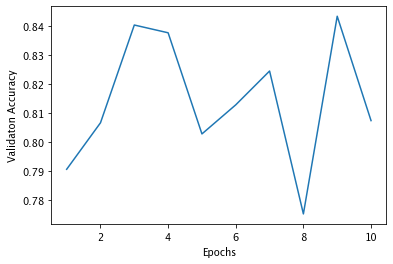

In [138]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Accuracy")
plt.show()

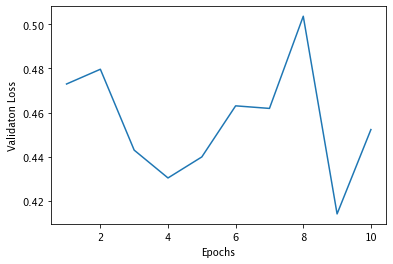

In [139]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Loss")
plt.show()

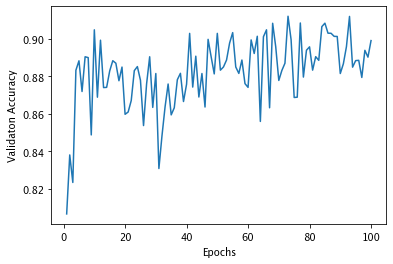

In [58]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Accuracy")
plt.show()

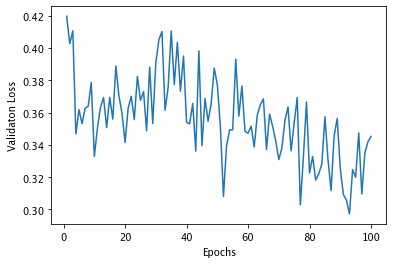

In [59]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Loss")
plt.show()

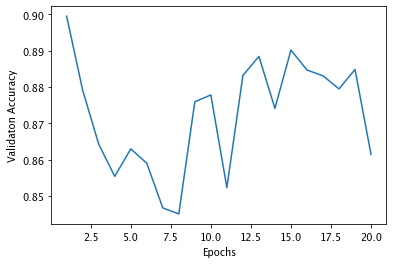

In [49]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Accuracy")
plt.show()

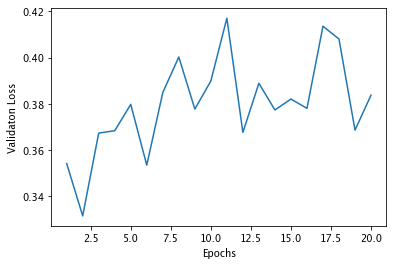

In [50]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Loss")
plt.show()

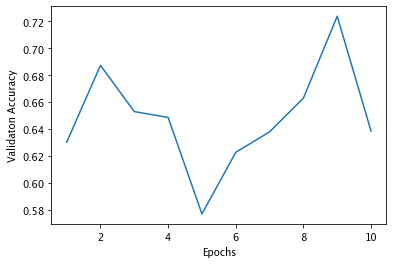

In [23]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Accuracy")
plt.show()

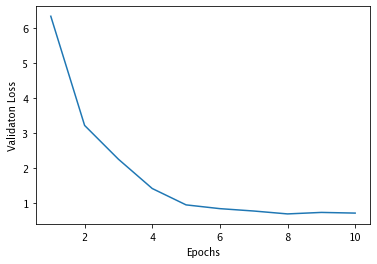

In [24]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Loss")
plt.show()

In [18]:
test_acc

[0.7142857313156128,
 0.6857143044471741,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7027027010917664,
 0.45945945382118225,
 0.7027027010917664,
 0.7027027010917664,
 0.7027027010917664,
 0.7027027010917664,
 0.6216216087341309]

In [81]:
average_acc = sum(test_acc)/len(test_acc)

In [299]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 6, 210, 64)        256       
                                                                 
 dropout_66 (Dropout)        (None, 6, 210, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 6, 210, 64)        12352     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 105, 64)       0         
 g2D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 6, 105, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 6, 105, 64)        12352     
                                                     

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)


y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
y_val = tf.keras.utils.to_categorical(y_val, num_output_class)

In [24]:
predictions = model.predict(X_train)

In [31]:
np.sum(predictions[0])

1.0973594

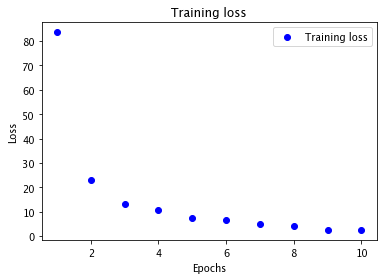

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

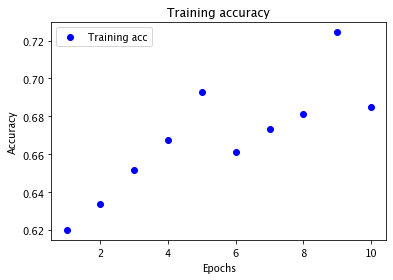

In [29]:
plt.clf()
acc = history_dict['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title("Training accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
train = [1,2,3,5]
test = [2,4]

df_test_train = pd.DataFrame(train, columns=['a'])
df_test_test = pd.DataFrame(test, columns=['a'])

In [100]:
df_test_train

,a
0,0.00
1,0.25
2,0.50
3,1.00


In [99]:
df_test_test

,a
0,0.0
1,1.0


In [98]:
df_test_train = (df_test_train-df_test_train.min())/(df_test_train.max()-df_test_train.min())
df_test_test = (df_test_test-df_test_test.min())/(df_test_test.max()-df_test_test.min())

# Fragen

- Wie und wann Labels entfernen?